## Importing relevant packages for finetuning

In [19]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print('=== setting gpu memory growth to True for gpu: ', gpu)
            tf.config.experimental.set_memory_growth(gpu, True) 
    except RuntimeError as e:
        print(e)

2025-02-08 13:12:42.237700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-08 13:12:42.237793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-02-08 13:12:42.237853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-02-08 13:12:42.237922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2025-02-08 13:12:42.288924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [21]:
import timesfm
import gc 
from timesfm import patched_decoder
from timesfm import data_loader

## Loading TimesFM pretrained checkpoint

In [4]:
timesfm_backend = "gpu"  # @param

tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend=timesfm_backend,
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          # Se this to True for v1.0 checkpoints
          use_positional_embedding=False,
          # Note that we could set this to as high as 2048 but keeping it 512 here so that
          # both v1.0 and 2.0 checkpoints work
          context_len=512,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-jax"),
  )

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

2025-02-07 14:50:38.037493: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.5 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Multiprocessing context has already been set.
Constructing model weights.


Constructed model weights in 7.48 seconds.
Restoring checkpoint from /home/fenrir/.cache/huggingface/hub/models--google--timesfm-2.0-500m-jax/snapshots/47dedfcadf2abace1cc96071ddb798cfcd3bfcef/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 3.36 seconds.
Jitting decoding.
Jitted decoding in 55.72 seconds.


## Evaluating pretrained checkpoint on ETT datasets

In [22]:
DATA_DICT = {
    "ettm2": {
        "boundaries": [34560, 46080, 57600],
        "data_path": "../datasets/ETT-small/ETTm2.csv",
        "freq": "15min",
    },
    "ettm1": {
        "boundaries": [34560, 46080, 57600],
        "data_path": "../datasets/all_six_datasets/ETT-small/ETTm1.csv",
        "freq": "15min",
    },
    "etth2": {
        "boundaries": [8640, 11520, 14400],
        "data_path": "../datasets/ETT-small/ETTh2.csv",
        "freq": "H",
    },
    "etth1": {
        "boundaries": [8640, 11520, 14400],
        "data_path": "../datasets/ETT-small/ETTh1.csv",
        "freq": "H",
    },
    "elec": {
        "boundaries": [18413, 21044, 26304],
        "data_path": "../datasets/electricity/electricity.csv",
        "freq": "H",
    },
    "traffic": {
        "boundaries": [12280, 14036, 17544],
        "data_path": "../datasets/traffic/traffic.csv",
        "freq": "H",
    },
    "weather": {
        "boundaries": [36887, 42157, 52696],
        "data_path": "../datasets/weather/weather.csv",
        "freq": "10min",
    },
}

In [23]:
data_df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462,9.567000
69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567000
69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426000
69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523,9.426000


In [24]:
dataset = "ettm1"
data_path = DATA_DICT[dataset]["data_path"]
freq = DATA_DICT[dataset]["freq"]
int_freq = timesfm.freq_map(freq)
boundaries = DATA_DICT[dataset]["boundaries"]

data_df = pd.read_csv(open(data_path, "r"))


ts_cols = [col for col in data_df.columns if col != "date"]
num_cov_cols = None
cat_cov_cols = None

context_len = 512
pred_len = 96

num_ts = len(ts_cols)
batch_size = 32

In [29]:
freq, freq, boundaries, ts_cols, boundaries

('15min',
 '15min',
 [35000, 50000, 69680],
 ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'],
 [35000, 50000, 69680])

In [30]:
boundaries = [35000, 50000, 69980]

In [31]:
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="date",
      num_cov_cols=num_cov_cols,
      cat_cov_cols=cat_cov_cols,
      ts_cols=np.array(ts_cols),
      train_range=[0, boundaries[0]],
      val_range=[boundaries[0], boundaries[1]],
      test_range=[boundaries[1], boundaries[2]],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=num_ts,
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )

In [9]:
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

2025-02-07 15:06:59.824943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    break
print(tbatch[0].shape)

0it [00:00, ?it/s]

(32, 7, 512)


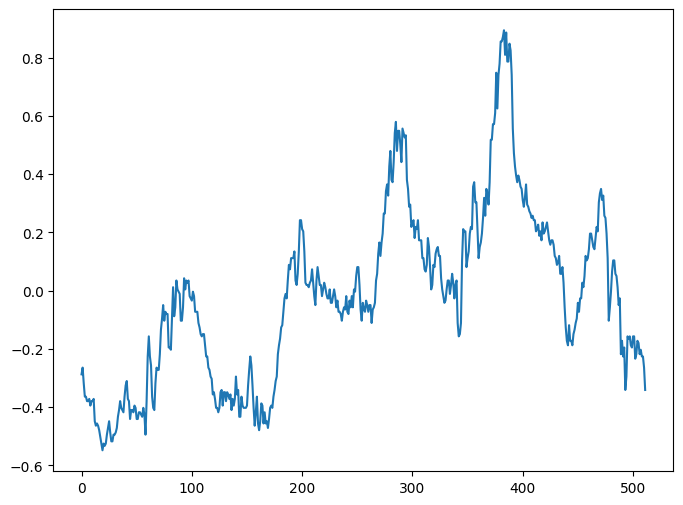

In [15]:
plt.plot(tbatch[0][3][1])

### MAE on the test split for the pretrained TimesFM model

In [14]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    forecasts, _ = tfm.forecast(list(past), [0] * past.shape[0], normalize=True)
    forecasts = forecasts[:, 0 : actuals.shape[1]]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

120it [00:05, 22.06it/s]

MAE: 0.33037744596019203


## Finetuning the model on the ETT dataset

In [11]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [12]:
# PAX shortcuts
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [13]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

### We will hold the transformer layers fixed while finetuning, while training all other components.

In [14]:
@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [15]:
task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [16]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: NVIDIA GeForce RTX 3090


In [17]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):
    past_ts = batch[0].reshape(batch_size * num_ts, -1)
    actual_ts = batch[3].reshape(batch_size * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

### Setting the initial model weights to the pretrained TimesFM parameters.

In [18]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

### Training loop

In [19]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [20]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [21]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 10
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='./ettm1_finetune'

In [22]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [23]:
total_train_loss = []
total_test_loss = []
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        total_train_loss.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])                
            mean_loss = np.mean(eval_losses)
            total_test_loss.append(mean_loss)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 2.8065481185913086
Starting eval.



 [00:00, ?it/s]
 [00:26, 26.50s/it]
 [00:26,  2.14s/it]
t [00:26,  1.15it/s]
t [00:26,  2.10it/s]
t [00:26,  3.43it/s]
t [00:27,  5.46it/s]
t [00:27,  8.21it/s]
t [00:27, 11.79it/s]
t [00:27, 16.49it/s]
t [00:27, 22.37it/s]
t [00:27, 29.39it/s]
it [00:27, 37.42it/s]
120it [00:27,  4.31it/s]

Eval loss at step 0: 3.294240713119507



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1000it [07:04,  3.00it/s]

Train loss at step 1000: 2.8055624961853027
Starting eval.



 [00:00, ?it/s]
 [00:00, 29.18it/s]
t [00:00, 58.33it/s]
t [00:00, 67.54it/s]
t [00:00, 72.38it/s]
t [00:00, 77.31it/s]
t [00:00, 79.52it/s]
t [00:00, 80.63it/s]
t [00:00, 81.36it/s]
t [00:00, 81.86it/s]
t [00:01, 82.10it/s]
t [00:01, 82.91it/s]
t [00:01, 83.04it/s]
it [00:01, 83.19it/s]
120it [00:01, 78.58it/s]

Eval loss at step 1000: 3.123889923095703



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


2000it [12:47,  3.00it/s]

Train loss at step 2000: 2.562800407409668
Starting eval.



 [00:00, ?it/s]
 [00:00,  8.85it/s]
 [00:00, 41.22it/s]
t [00:00, 53.45it/s]
t [00:00, 61.42it/s]
t [00:00, 64.10it/s]
t [00:00, 66.82it/s]
t [00:00, 68.57it/s]
t [00:00, 69.99it/s]
t [00:00, 70.83it/s]
t [00:01, 71.60it/s]
t [00:01, 71.42it/s]
t [00:01, 71.81it/s]
t [00:01, 72.61it/s]
it [00:01, 72.64it/s]
it [00:01, 73.04it/s]
120it [00:01, 67.69it/s]

Eval loss at step 2000: 3.104106903076172



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


2122it [13:37,  2.59it/s]

__________________Epoch: 1__________________



878it [04:53,  3.00it/s]

Train loss at step 3000: 2.6595330238342285
Starting eval.



 [00:00, ?it/s]
 [00:00, 29.86it/s]
t [00:00, 52.85it/s]
t [00:00, 62.70it/s]
t [00:00, 67.74it/s]
t [00:00, 70.09it/s]
t [00:00, 72.72it/s]
t [00:00, 73.17it/s]
t [00:00, 74.09it/s]
t [00:00, 74.90it/s]
t [00:01, 75.21it/s]
t [00:01, 74.93it/s]
t [00:01, 75.41it/s]
t [00:01, 75.40it/s]
it [00:01, 74.90it/s]
120it [00:01, 71.94it/s]


Eval loss at step 3000: 3.062966823577881


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1878it [10:36,  3.00it/s]

Train loss at step 4000: 2.8638784885406494
Starting eval.



 [00:00, ?it/s]
 [00:00, 27.63it/s]
t [00:00, 55.67it/s]
t [00:00, 65.18it/s]
t [00:00, 70.24it/s]
t [00:00, 75.64it/s]
t [00:00, 77.96it/s]
t [00:00, 79.70it/s]
t [00:00, 79.75it/s]
t [00:00, 80.78it/s]
t [00:01, 81.80it/s]
t [00:01, 81.90it/s]
t [00:01, 80.75it/s]
it [00:01, 81.60it/s]
120it [00:01, 77.16it/s]

Eval loss at step 4000: 3.0791518688201904



1881it [10:39,  1.37it/s]

patience: 1


2122it [11:59,  2.95it/s]

__________________Epoch: 2__________________



756it [04:12,  3.06it/s]

Train loss at step 5000: 2.1690666675567627
Starting eval.



 [00:00, ?it/s]
 [00:00, 29.14it/s]
t [00:00, 58.45it/s]
t [00:00, 71.23it/s]
t [00:00, 77.39it/s]
t [00:00, 79.53it/s]
t [00:00, 80.88it/s]
t [00:00, 81.99it/s]
t [00:00, 82.79it/s]
t [00:00, 82.88it/s]
t [00:01, 83.46it/s]
t [00:01, 83.98it/s]
it [00:01, 84.08it/s]
it [00:01, 84.54it/s]
120it [00:01, 80.08it/s]

Eval loss at step 5000: 3.072042942047119



759it [04:16,  1.41it/s]

patience: 2


1756it [09:47,  2.98it/s]

Train loss at step 6000: 2.3455493450164795
Starting eval.



 [00:00, ?it/s]
 [00:00, 29.87it/s]
t [00:00, 56.22it/s]
t [00:00, 64.59it/s]
t [00:00, 72.43it/s]
t [00:00, 77.12it/s]
t [00:00, 76.49it/s]
t [00:00, 76.02it/s]
t [00:00, 78.54it/s]
t [00:00, 80.29it/s]
t [00:01, 81.87it/s]
t [00:01, 82.07it/s]
t [00:01, 82.53it/s]
it [00:01, 80.49it/s]
120it [00:01, 76.25it/s]

Eval loss at step 6000: 3.0592539310455322


Saving checkpoint.


        shapes of train_state  as the unpadded shapes.
2122it [11:59,  2.95it/s]

__________________Epoch: 3__________________



634it [03:31,  2.99it/s]

Train loss at step 7000: 2.609969139099121
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.63it/s]
t [00:00, 71.59it/s]
t [00:00, 78.37it/s]
t [00:00, 87.49it/s]
t [00:00, 91.66it/s]
t [00:00, 94.15it/s]
t [00:00, 95.94it/s]
t [00:00, 96.85it/s]
t [00:00, 96.97it/s]
t [00:01, 96.85it/s]
it [00:01, 95.73it/s]
120it [00:01, 91.87it/s]


Eval loss at step 7000: 3.050753355026245


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1634it [09:14,  3.00it/s]

Train loss at step 8000: 2.2809691429138184
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.78it/s]
t [00:00, 76.26it/s]
t [00:00, 88.09it/s]
t [00:00, 93.63it/s]
t [00:00, 95.34it/s]
t [00:00, 94.93it/s]
t [00:00, 95.53it/s]
t [00:00, 95.84it/s]
t [00:00, 96.06it/s]
t [00:01, 96.25it/s]
it [00:01, 96.55it/s]
120it [00:01, 93.02it/s]

Eval loss at step 8000: 3.056668996810913



1637it [09:17,  1.43it/s]

patience: 1


2122it [11:58,  2.95it/s]

__________________Epoch: 4__________________



512it [02:50,  3.04it/s]

Train loss at step 9000: 2.1614339351654053
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.88it/s]
t [00:00, 77.32it/s]
t [00:00, 89.20it/s]
t [00:00, 94.78it/s]
t [00:00, 95.23it/s]
t [00:00, 94.93it/s]
t [00:00, 94.76it/s]
t [00:00, 94.78it/s]
t [00:00, 95.93it/s]
t [00:01, 96.20it/s]
it [00:01, 96.56it/s]
120it [00:01, 93.10it/s]

Eval loss at step 9000: 3.0814831256866455



515it [02:54,  1.46it/s]

patience: 2


1512it [08:26,  2.23it/s]

Train loss at step 10000: 1.8938796520233154
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.77it/s]
t [00:00, 73.59it/s]
t [00:00, 85.34it/s]
t [00:00, 90.86it/s]
t [00:00, 94.03it/s]
t [00:00, 95.80it/s]
t [00:00, 96.96it/s]
t [00:00, 97.85it/s]
t [00:00, 95.87it/s]
t [00:01, 96.93it/s]
it [00:01, 97.22it/s]
120it [00:01, 93.37it/s]


Eval loss at step 10000: 3.071993112564087


1515it [08:29,  1.48it/s]

patience: 3


2122it [11:50,  2.99it/s]

__________________Epoch: 5__________________



390it [02:10,  3.00it/s]

Train loss at step 11000: 2.4392096996307373
Starting eval.



 [00:00, ?it/s]
 [00:00, 37.95it/s]
t [00:00, 72.86it/s]
t [00:00, 84.19it/s]
t [00:00, 87.26it/s]
t [00:00, 91.35it/s]
t [00:00, 94.03it/s]
t [00:00, 95.65it/s]
t [00:00, 96.86it/s]
t [00:00, 97.28it/s]
t [00:01, 93.67it/s]
it [00:01, 94.48it/s]
120it [00:01, 91.68it/s]


Eval loss at step 11000: 3.066112756729126


393it [02:13,  1.43it/s]

patience: 4


1390it [07:45,  3.02it/s]

Train loss at step 12000: 2.569077968597412
Starting eval.



 [00:00, ?it/s]
 [00:00, 47.54it/s]
t [00:00, 70.88it/s]
t [00:00, 80.95it/s]
t [00:00, 89.10it/s]
t [00:00, 90.45it/s]
t [00:00, 93.37it/s]
t [00:00, 95.98it/s]
t [00:00, 97.92it/s]
t [00:00, 98.34it/s]
t [00:01, 98.77it/s]
it [00:01, 99.37it/s]
120it [00:01, 92.76it/s]

Eval loss at step 12000: 3.0863163471221924



1391it [07:48,  1.23s/it]

patience: 5
Early stopping.


1391it [07:48,  2.97it/s]

__________________Epoch: 6__________________


Early stopping.


In [32]:
train_loss = [t.item() for t in total_train_loss]
test_loss = [t.item() for t in total_test_loss]

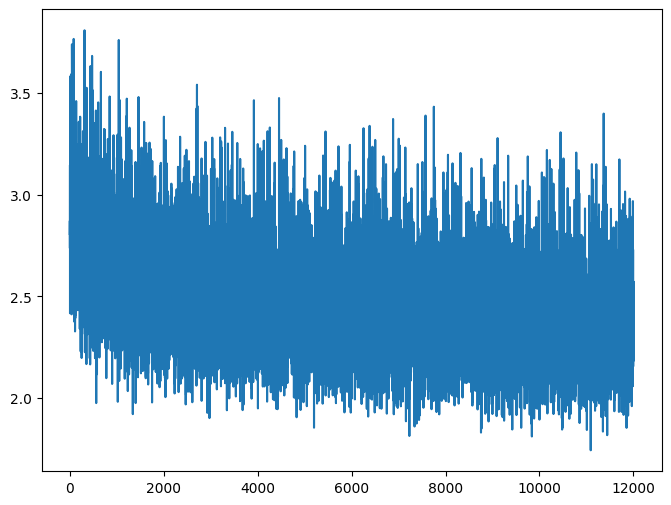

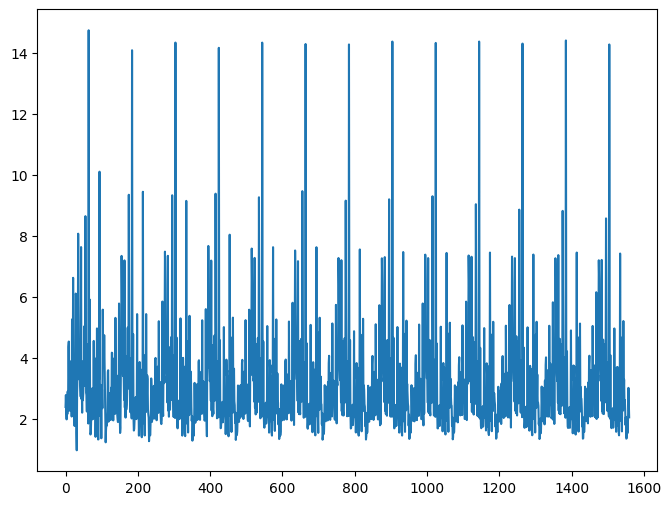

In [42]:
plt.plot(range(len(train_loss)), train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

## Loading and evaluating the best (according to validation loss) finetuned checkpoint

In [24]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


7001
Jitting decoding.
Jitted decoding in 46.67 seconds.


In [25]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

120it [00:05, 23.25it/s]

MAE: 0.30829155445098877


## There is around a __7%__ reduction in MAE from finetuning.

In [43]:
(0.3303774 - 0.30829155) / 0.3303774

0.06685036567271237